In [4]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


In [5]:
#Step 2 : Read the dataset using pandas
df = pd.read_csv("base_data2.csv")
df.drop(['CLASS','DT','YEAR','HML_SI_CAT','HML_SI_BIN'],axis=1,inplace=True)


In [6]:
#Step 3:Define X and y
X= df[['CORR_PRODUCTION','CORR_NC_RATE','CORR_COKE_RATE','CORR_COAL_RATE','HM_TEMP','QUARTZ_RATE','LIMESTONE_RATE','SLAG_RATE','PYROXINITE_RATE','SINTER_PERC','PELLET_PERC','HOT_BLAST_TEMP','COLD_BLAST_O2_ENRICH','COLD_BLAST_HUMID','FUR_RAFT_TEMP','COMP_COLD_BLAST_FLOW','UPTAKE_AVG','HL_TOTAL_GJ_HR','UPPER_K','MIDDLE_K','LOWER_K','K','HML_S','HML_SIO2','HML_MGO','HML_AL2O3','HML_CAO_SIO2','COK_MOISTURE','COK_CSR','COK_CRI','COK_AMS','SIN_CAO_SIO2','SIN_MGO']]
y = df.HML_SI

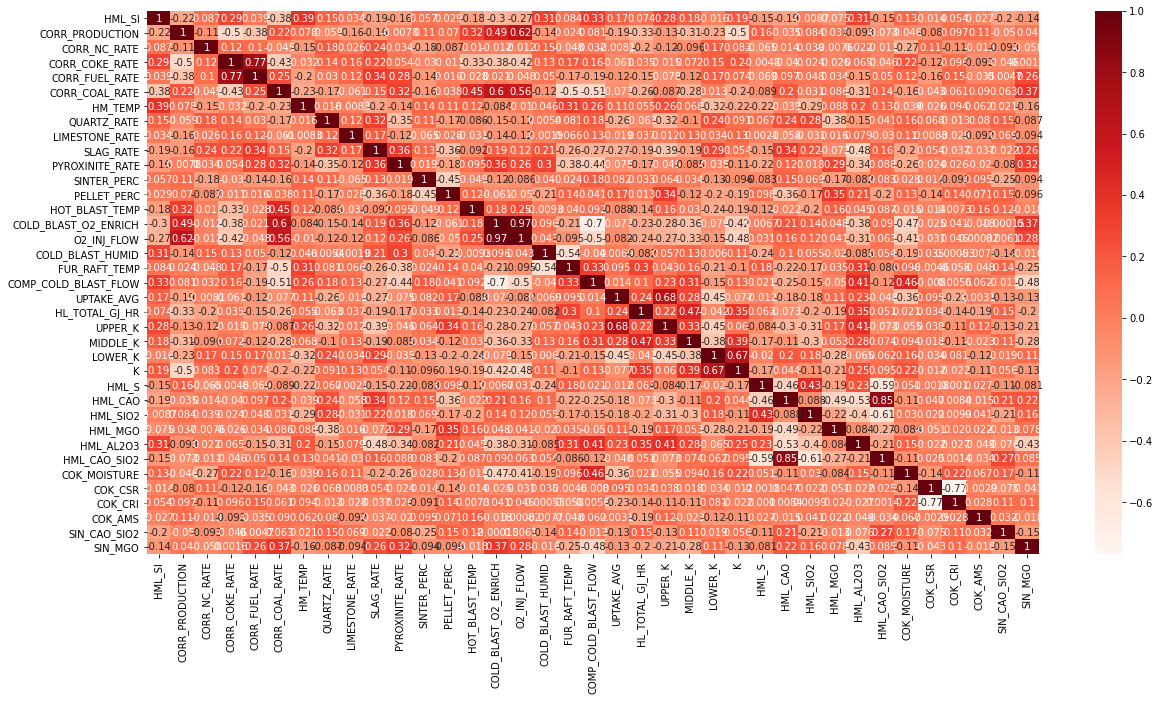

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
#Correlation with output variable
cor_target = abs(cor["HML_SI"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

HML_SI                  1.000000
CORR_COAL_RATE          0.382824
HM_TEMP                 0.385155
COLD_BLAST_HUMID        0.307373
COMP_COLD_BLAST_FLOW    0.325069
HML_AL2O3               0.309119
Name: HML_SI, dtype: float64

In [9]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const                   1.005083e-02
CORR_PRODUCTION         9.443298e-01
CORR_NC_RATE            9.868859e-02
CORR_COKE_RATE          6.383732e-03
CORR_COAL_RATE          2.812368e-02
HM_TEMP                 1.365095e-12
QUARTZ_RATE             3.217893e-07
LIMESTONE_RATE          5.928435e-01
SLAG_RATE               2.845582e-06
PYROXINITE_RATE         2.160737e-01
SINTER_PERC             6.662750e-01
PELLET_PERC             2.123111e-01
HOT_BLAST_TEMP          2.220312e-05
COLD_BLAST_O2_ENRICH    6.215862e-01
COLD_BLAST_HUMID        4.215481e-06
FUR_RAFT_TEMP           3.997998e-03
COMP_COLD_BLAST_FLOW    3.590302e-01
UPTAKE_AVG              1.917703e-01
HL_TOTAL_GJ_HR          1.790635e-02
UPPER_K                 3.543997e-01
MIDDLE_K                3.686623e-01
LOWER_K                 3.695699e-01
K                       3.774498e-01
HML_S                   1.734643e-09
HML_SIO2                3.649162e-01
HML_MGO                 2.270534e-04
HML_AL2O3               2.999772e-01
H

In [10]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05  ):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)


['CORR_COKE_RATE', 'CORR_COAL_RATE', 'HM_TEMP', 'QUARTZ_RATE', 'SLAG_RATE', 'HOT_BLAST_TEMP', 'COLD_BLAST_HUMID', 'FUR_RAFT_TEMP', 'COMP_COLD_BLAST_FLOW', 'HL_TOTAL_GJ_HR', 'UPPER_K', 'MIDDLE_K', 'LOWER_K', 'HML_S', 'HML_MGO', 'HML_AL2O3', 'HML_CAO_SIO2', 'SIN_CAO_SIO2', 'SIN_MGO']


In [11]:
print(len(selected_features_BE))

19


In [12]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)


[False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True False
 False False  True False False False False  True False]
[27 18 20 15  8 11 26 17 22 24 21 14  4  6 16 19 23 25  1  1  1  1  1 10
  2  3  1 12 13  9  7  1  5]


In [13]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20604, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print()

Optimum number of features: 11
Score with 11 features: 0.303631



In [14]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['COLD_BLAST_O2_ENRICH', 'UPPER_K', 'MIDDLE_K', 'LOWER_K', 'K', 'HML_S',
       'HML_MGO', 'HML_AL2O3', 'HML_CAO_SIO2', 'SIN_CAO_SIO2'],
      dtype='object')


In [15]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.011214
Best score using built-in LassoCV: 0.448591


In [17]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 22 variables


Text(0.5, 1.0, 'Feature importance')

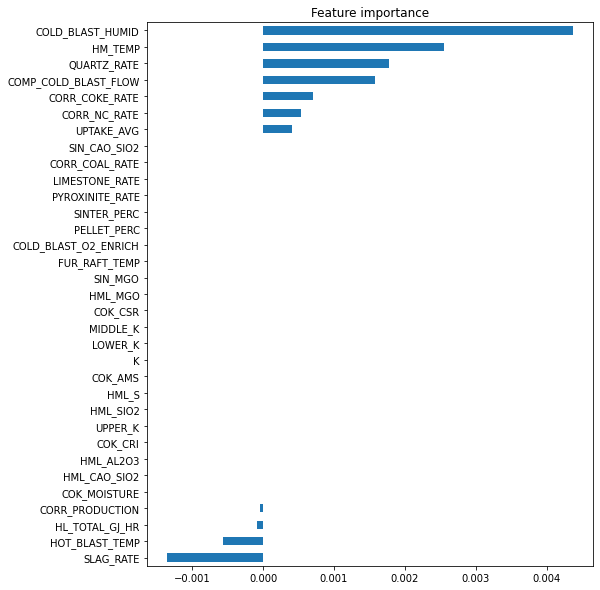

In [18]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance")